Finding Dominant Color Names from Color Space Coordinates and Images
=========================================

![](jupysmug.png)

### Let's install some software.

This notebook will explore various techniques for analyzing the contents of digital images
and computing:

1.  Color names from RGB color space coordinates.

2.  Finding a color "nearest" a preset pallette of colors.

3.  Computing an image's dominant color and returning a "nearest" color name.

The methods tested here were collected from many 
sources, ["Lesser artists borrow, great artists steal."](https://www.brainyquote.com/quotes/igor_stravinsky_137813)
One of these days I will have to blog about the difference between ***programming***, *thinking for yourself*,
and ***gargling***, *looking up code snippets on the web.* 

Testing disparate code snippets always turns into a configuration exercise.
The following install commands gather required packages that I didn't find in the Anaconda distribution.

In [ ]:
!cd \anaconda3
!python -m pip install webcolors

In [ ]:
!cd \anaconda3
!python -m pip install Pillow

### Notebook Imports

In [1]:
import webcolors
import numpy as np
import struct
from PIL import Image
from matplotlib import pyplot as plt
import scipy
import scipy.misc
import scipy.cluster
from collections import namedtuple
from math import sqrt
import random
from sklearn.cluster import KMeans

### Using `webcolors` to Reverse Color Code.

After installing `webcolors` test it with this code snippet from [Stack Overflow](https://stackoverflow.com/questions/9694165/convert-rgb-color-to-english-color-name-like-green-with-python).

In [2]:
def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.css3_hex_to_names.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name

requested_colour = (119, 172, 152)
actual_name, closest_name = get_colour_name(requested_colour)

print("Actual colour name:", actual_name, ", closest colour name:", closest_name)

Actual colour name: None , closest colour name: cadetblue


In [3]:
rgb0 = (0,0,0)
rgb1 = (255,255,255)
rgb2 = (255,0,0)
rgb3 = (0,255,0)
rgb4 = (0,0,255)

print(get_colour_name(rgb0))
print(get_colour_name(rgb1))
print(get_colour_name(rgb2))
print(get_colour_name(rgb3))
print(get_colour_name(rgb4))

('black', 'black')
('white', 'white')
('red', 'red')
('lime', 'lime')
('blue', 'blue')


### Generate Some Random Colors

In [4]:
print(random.randint(0, 255))

115


In [5]:
for a,b in 15 * [(0,255)]:
    rgb = (random.randint(a,b), random.randint(a,b), random.randint(a,b))
    print(get_colour_name(rgb)[-1])

yellowgreen
grey
cornflowerblue
seagreen
crimson
darkslateblue
darkslateblue
darkslateblue
olivedrab
magenta
blueviolet
crimson
mediumorchid
darkslateblue
darkseagreen


### Loading Test Images

The following images, selected from the 
directories [generated by](https://github.com/bakerjd99/smugpyter/blob/master/notebooks/smugpyter.py) `SmugPyter`,
will be used to test various dominant color calculations.

In [6]:
image1 = Image.open('C:/SmugMirror/Themes/Manipulations/ImageHacking/5NB7dXP-1f-green-gray-dragon-eggs.jpg')
image2 = Image.open('C:/SmugMirror/Themes/Manipulations/ImageHacking/hjbftwN-1-your-grainy-hell-awaits-[409595101].jpg')
image3 = Image.open('C:/SmugMirror/People/GreatandGreaterForebearers/LX8HmDV-2z-william-evert-baker-portrait-1950.jpg')
image4 = Image.open('C:/SmugMirror/Themes/Manipulations/Panoramas/b36sc3H-1-norris-porcelain-basin-yellowstone-panorma.jpg')

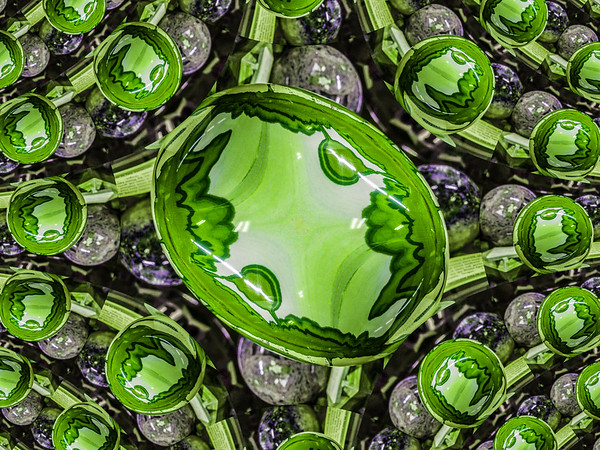

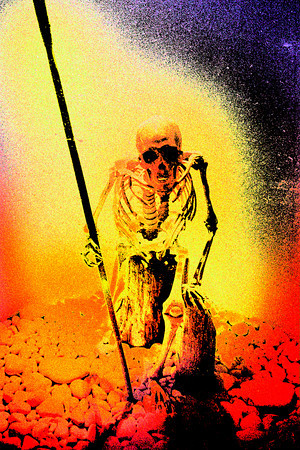

In [7]:
display(image1)
display(image2)

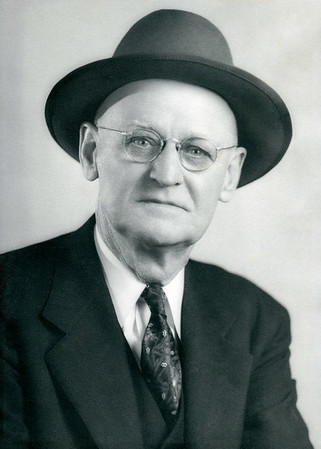

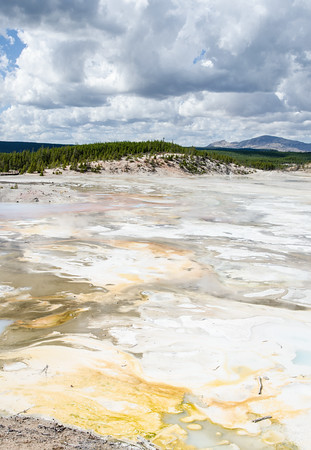

In [8]:
display(image3)
display(image4)

### Define Display Utilities

Before running through the dominant color calculations let's define a few display utilities.

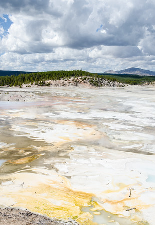

In [9]:
def resize_image(image, factor):
    """Resize PIL image maintaining aspect ratio."""
    imcopy = image.copy()
    width, height = imcopy.size
    width = int(factor * width)
    height = int(factor * height) 
    return imcopy.resize((width, height))

imnew = resize_image(image4, 0.5)
display(imnew)

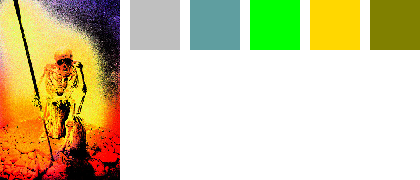

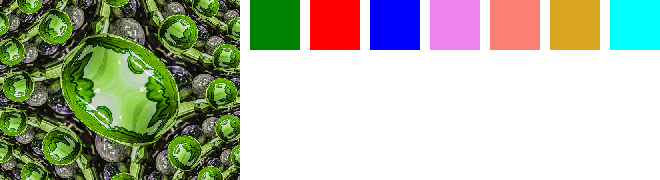

In [10]:
def show_image_name_colors(image, color_names, *, factor=0.4, patch_size=(50,50), spacing=10):
    """Display resized image with adjacent named color patches."""
    imnew = resize_image(image, factor)
    # NIMP check that image is larger than patch size
    height = imnew.size[1]
    width = imnew.size[0] + (spacing + patch_size[0]) * len(color_names)
    background = Image.new('RGBA', (width,height), (255, 255, 255, 255))
    background.paste(imnew, (0,0))
    for i, name in enumerate(color_names):
        patch = Image.new("RGB", patch_size, name)
        background.paste(patch, (imnew.size[0] + spacing +  i * (spacing + patch_size[0]), 0))
    display(background)

show_image_name_colors(image2, ["silver","cadetblue","lime","gold","olive"])
show_image_name_colors(image1, ["green","red","blue","violet","salmon","goldenrod","cyan"])    

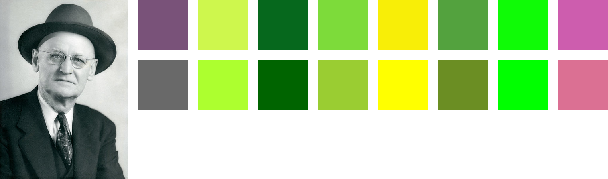

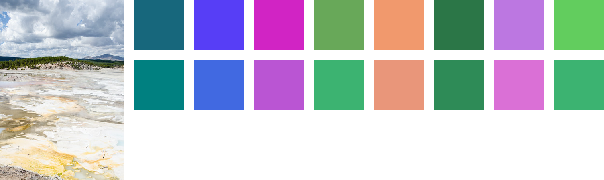

In [11]:
def show_image_colors(image, colors, *, factor=0.4, patch_size=(50,50), spacing=10):
    """
    Display resized image with adjacent color patches.
    The top patch row shows raw colors and the second
    shows nearest named colors.
    """
    imnew = resize_image(image, factor)
    # NIMP check that image is 2 * larger than patch size.
    height = imnew.size[1]
    width = imnew.size[0] + (spacing + patch_size[0]) * len(colors)
    background = Image.new('RGBA', (width,height), (255, 255, 255, 255))
    background.paste(imnew, (0,0))
    for i, color in enumerate(colors):
        r, g, b = color
        patch1 = Image.new("RGB", patch_size, (int(r),int(g),int(b)))
        background.paste(patch1, (imnew.size[0] + spacing +  i * (spacing + patch_size[0]), 0))
        name = get_colour_name((r,g,b))[-1]
        patch2 = Image.new("RGB", patch_size, name)
        background.paste(patch2, (imnew.size[0] + spacing +  i * (spacing + patch_size[0]), spacing + patch_size[1]))
    display(background)

rcolors0 = []
rcolors1 = []
for a,b in 8 * [(0,255)]:
    rgb0 = (random.randint(a,b), random.randint(a,b), random.randint(a,b))
    rgb1 = (random.randint(a,b), random.randint(a,b), random.randint(a,b))
    rcolors0.append(rgb0)
    rcolors1.append(rgb1)
    
show_image_colors(image3, rcolors0)
show_image_colors(image4, rcolors1)    

### First Dominant Color Calculation

After making some minor code edits it's possible to 
run this [algorithm from Stack Overflow](https://stackoverflow.com/questions/3241929/python-find-dominant-most-common-color-in-an-image).

In [12]:
NUM_CLUSTERS = 8

ar1 = np.asarray(image1)
ar2 = np.asarray(image2)
ar3 = np.asarray(image3)
ar4 = np.asarray(image4)
shape1 = ar1.shape
shape2 = ar2.shape
shape3 = ar3.shape
shape4 = ar4.shape
ar1 = ar1.reshape(scipy.product(shape1[:2]), shape1[2]).astype(float)
ar2 = ar2.reshape(scipy.product(shape2[:2]), shape2[2]).astype(float)
ar3 = ar3.reshape(scipy.product(shape3[:2]), shape3[2]).astype(float)
ar4 = ar4.reshape(scipy.product(shape4[:2]), shape4[2]).astype(float)

print('finding clusters')
codes1, dist1 = scipy.cluster.vq.kmeans(ar1, NUM_CLUSTERS)
codes2, dist2 = scipy.cluster.vq.kmeans(ar2, NUM_CLUSTERS)
codes3, dist3 = scipy.cluster.vq.kmeans(ar3, NUM_CLUSTERS)
codes4, dist4 = scipy.cluster.vq.kmeans(ar4, NUM_CLUSTERS)

vecs1, dist1 = scipy.cluster.vq.vq(ar1, codes1)       # assign codes
counts1, bins1 = scipy.histogram(vecs1, len(codes1))  # count occurrences
vecs2, dist2 = scipy.cluster.vq.vq(ar2, codes2)       
counts2, bins2 = scipy.histogram(vecs2, len(codes2))  
vecs3, dist3 = scipy.cluster.vq.vq(ar3, codes3)       
counts3, bins3 = scipy.histogram(vecs3, len(codes3))  
vecs4, dist4 = scipy.cluster.vq.vq(ar4, codes4)       
counts4, bins4 = scipy.histogram(vecs4, len(codes4))  

index_max1 = scipy.argmax(counts1)                    # find most frequent
peak1 = codes1[index_max1]
index_max2 = scipy.argmax(counts2)                    
peak2 = codes2[index_max2]
index_max3 = scipy.argmax(counts3)                    
peak3 = codes3[index_max3]
index_max4 = scipy.argmax(counts4)                    
peak4 = codes4[index_max4]
print('peak1', peak1)
print('peak2', peak2)
print('peak3', peak3)
print('peak4', peak4)

finding clusters
peak1 [ 18.34328358  24.03461019  10.79475455]
peak2 [ 240.63540135  222.90668186  133.2013746 ]
peak3 [ 225.13256284  227.12192118  223.49106353]
peak4 [ 240.52535718  238.83926819  234.03380958]


### Display Cluster and Named Colors for the First Calculation

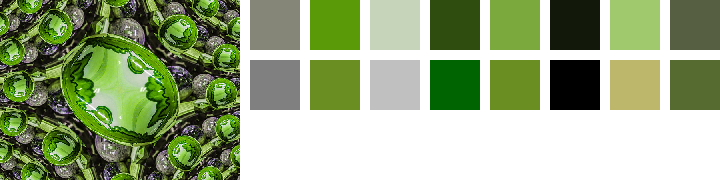

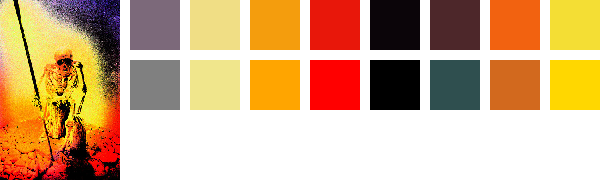

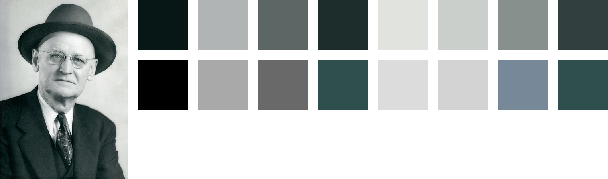

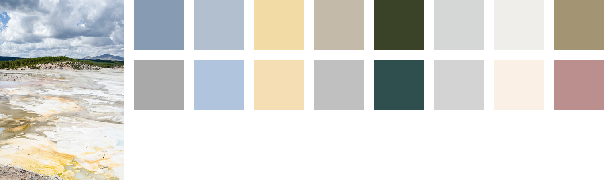

In [13]:
show_image_colors(image1, codes1)   
show_image_colors(image2, codes2)
show_image_colors(image3, codes3)
show_image_colors(image4, codes4)

### Second Dominant Color Calculation

This algorithm, due to [Charlies Leifer](https://charlesleifer.com/blog/using-python-and-k-means-to-find-the-dominant-colors-in-images/), also computes dominant colors.

In [14]:
Point = namedtuple('Point', ('coords', 'n', 'ct'))
Cluster = namedtuple('Cluster', ('points', 'center', 'n'))

def get_points(img):
    points = []
    w, h = img.size
    for count, color in img.getcolors(w * h):
        points.append(Point(color, 3, count))
    return points

rtoh = lambda rgb: '#%s' % ''.join(('%02x' % p for p in rgb))

def colorz2(image, *, n=3):
    img = image.copy()
    img.thumbnail((200, 200))
    w, h = img.size

    points = get_points(img)
    clusters = kmeans(points, n, 1)
    rgbs = [map(int, c.center.coords) for c in clusters]
    return map(rtoh, rgbs)

def euclidean(p1, p2):
    return sqrt(sum([
        (p1.coords[i] - p2.coords[i]) ** 2 for i in range(p1.n)
    ]))

def calculate_center(points, n):
    vals = [0.0 for i in range(n)]
    plen = 0
    for p in points:
        plen += p.ct
        for i in range(n):
            vals[i] += (p.coords[i] * p.ct)
    return Point([(v / plen) for v in vals], n, 1)

def kmeans(points, k, min_diff):
    clusters = [Cluster([p], p, p.n) for p in random.sample(points, k)]

    while 1:
        plists = [[] for i in range(k)]

        for p in points:
            smallest_distance = float('Inf')
            for i in range(k):
                distance = euclidean(p, clusters[i].center)
                if distance < smallest_distance:
                    smallest_distance = distance
                    idx = i
            plists[idx].append(p)

        diff = 0
        for i in range(k):
            old = clusters[i]
            center = calculate_center(plists[i], old.n)
            new = Cluster(plists[i], center, old.n)
            clusters[i] = new
            diff = max(diff, euclidean(old.center, new.center))

        if diff < min_diff:
            break

    return clusters

In [15]:
dmap1 = colorz2(image1, n=8)
dmap2 = colorz2(image2, n=8)
dmap3 = colorz2(image3, n=8)
dmap4 = colorz2(image4, n=8)
colors1 = [webcolors.hex_to_rgb(i) for i in list(dmap1)]
colors2 = [webcolors.hex_to_rgb(i) for i in list(dmap2)]
colors3 = [webcolors.hex_to_rgb(i) for i in list(dmap3)]
colors4 = [webcolors.hex_to_rgb(i) for i in list(dmap4)]

### Display Cluster and Named Colors for the Second Calculation

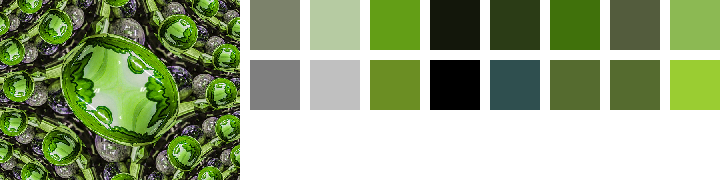

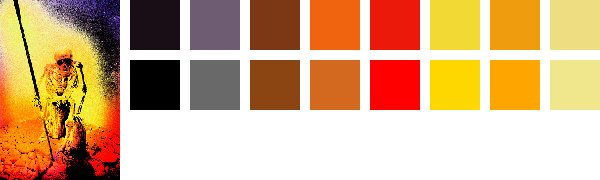

In [16]:
show_image_colors(image1, colors1)
show_image_colors(image2, colors2)

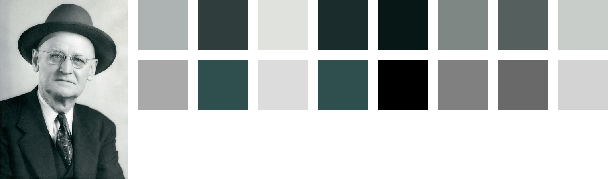

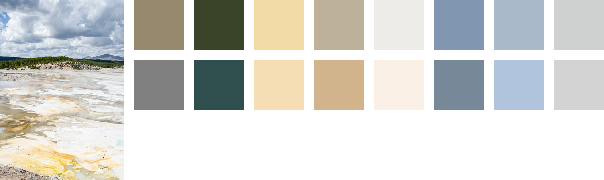

In [17]:
show_image_colors(image3, colors3)
show_image_colors(image4, colors4)

## Third Dominant Color Calculation

This algorithm, due to [Srijan Anand](https://github.com/srijannnd/Dominant-Color-Extraction-Dominance-and-Recoloring), is another variation on *kmeans*. The original notebook code required
some changes as `cv2` is not currently available for Python 3.6 Win64 Anaconda systems. It can be replaced
with `PIL`.

In [18]:
km = KMeans(n_clusters=8)
print(km)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [19]:
def calc3_colors(image):
    image = resize_image(image, factor=0.4)
    ar = np.asarray(image)
    shape = ar.shape
    pixels = ar.reshape((-1, 3))
    km.fit(pixels)
    colors = np.asarray(km.cluster_centers_, dtype='uint8')
    return colors

colors1 = calc3_colors(image1)
colors2 = calc3_colors(image2)
colors3 = calc3_colors(image3)
colors4 = calc3_colors(image4)

### Display Cluster and Named Colors for the Third Calculation

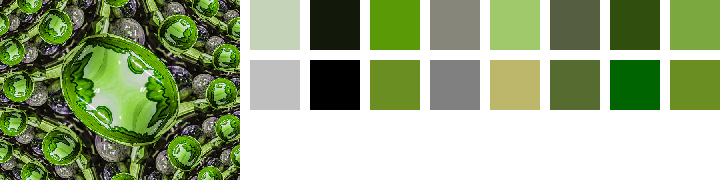

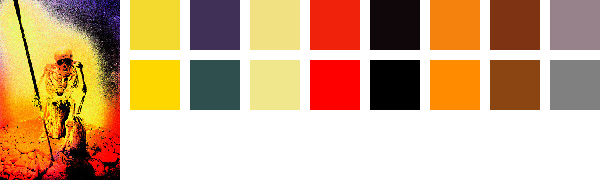

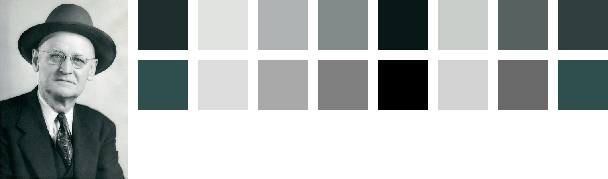

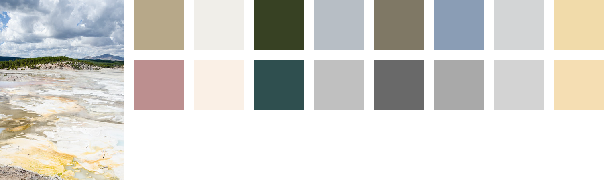

In [20]:
show_image_colors(image1, colors1)
show_image_colors(image2, colors2)
show_image_colors(image3, colors3)
show_image_colors(image4, colors4)

In [ ]:
dom = [[percentage[ix], colors[ix]] for ix in range(km.n_clusters)]
dominance = sorted(dom, key=lambda x:x[0], reverse=True)

In [ ]:
plt.figure(0)
plt.axis('off')

patch = np.zeros((50, 500, 3))

start = 0
for cx in range(km.n_clusters):
    width = int(dominance[cx][0] * patch.shape[1])
    end = start + width
    patch[:, start:end, :] = 255 - dominance[cx][1]
    start = end
plt.imshow(patch)
plt.show()